In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the model
model = VGG16()

# Summary of the model
model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# HOW TO VISUALIZE
In neural network terminology, the learned filters are simply weights, yet because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be).

The model summary printed in the previous section summarizes the output shape of each layer, e.g. the shape of the resulting feature maps. It does not give any idea of the shape of the filters (weights) in the network, only the total number of weights per layer.

We can access all of the layers of the model via the model.layers property.

Each layer has a layer.name property, where the convolutional layers have a naming convolution like block#_conv#, where the ‘#‘ is an integer. Therefore, we can check the name of each layer and skip any that don’t contain the string ‘conv‘.

Each convolutional layer has two sets of weights.
One is the block of filters and the other is the block of bias values. These are accessible via the layer.get_weights() function. We can retrieve these weights and then summarize their shape.

In [3]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


We see each layer has 3x3 filters.

We can see that for the input image with three channels for red, green and blue, that each filter has a depth of three (here we are working with a channel-last format). We could visualize one filter as a plot with three images, one for each channel, or compress all three down to a single color image, or even just look at the first channel and assume the other channels will look the same. The problem is, we then have 63 other filters that we might like to visualize.

We can retrieve the filters from the first layer as follows:

In [4]:
# retrieve weights from the second hidden layer
filters , bias = model.layers[1].get_weights()

The weight values will likely be small positive and negative values centered around 0.0.

We can normalize their values to the range 0-1 to make them easy to visualize.

In [5]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

We will be visualising 6 filters out of 64 filters from 1st layer.

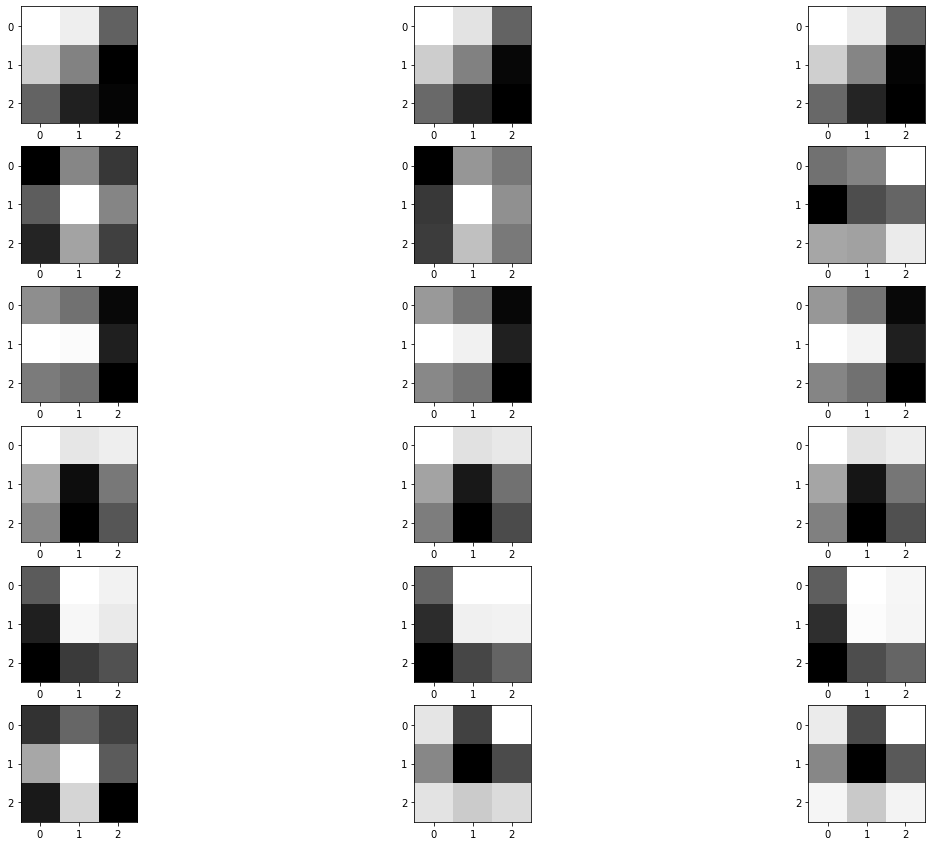

In [6]:
n_filters =6
ix=1
fig = pyplot.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        pyplot.subplot(n_filters,3,ix)
        pyplot.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
pyplot.show()

We can see that in some cases, the filter is the same across the channels (the first row), and in others, the filters differ (the last row).

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.

Note:

# Note:
Although we have a visualization, we only see the first six of the 64 filters in the first convolutional layer. Visualizing all 64 filters in one image is feasible.

Sadly, this does not scale; if we wish to start looking at filters in the second convolutional layer, we can see that again we have 64 filters, but each has 64 channels to match the input feature maps. To see all 64 channels in a row for all 64 filters would require (64×64) 4,096 subplots in which it may be challenging to see any detail.

# How to Visualize Feature Maps
The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map.

The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

For the input I will be using an image of my childhood crush Hermoine Granger(Emma Watson).

## Note:
we need a clearer idea of the shape of the feature maps output by each of the convolutional layers and the layer index number so that we can retrieve the appropriate layer output.

In [7]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


We can use this information and design a new model that is a subset of the layers in the full VGG16 model. The model would have the same input layer as the original model, but the output would be the output of a given convolutional layer, which we know would be the activation of the layer or the feature map.

In [8]:
model = Model(inputs=model.inputs , outputs=model.layers[1].output)

Making a prediction with this model will give the feature map for the first convolutional layer for a given provided input image. Let’s implement this.

After defining the model, we need to load the image with the size expected by the model, in this case, 224×224.

In [9]:
image = load_img("/content/drive/MyDrive/bird.jpg" , target_size=(224,224))

In [10]:
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

The pixel values then need to be scaled appropriately for the VGG model.

In [11]:
image = preprocess_input(image)

We are now ready to get the feature map. We can do this easy by calling the model.predict() function and passing in the prepared single image. We know the result will be a feature map with 224x224x64. We can plot all 64 two-dimensional images as an 8×8 square of images.

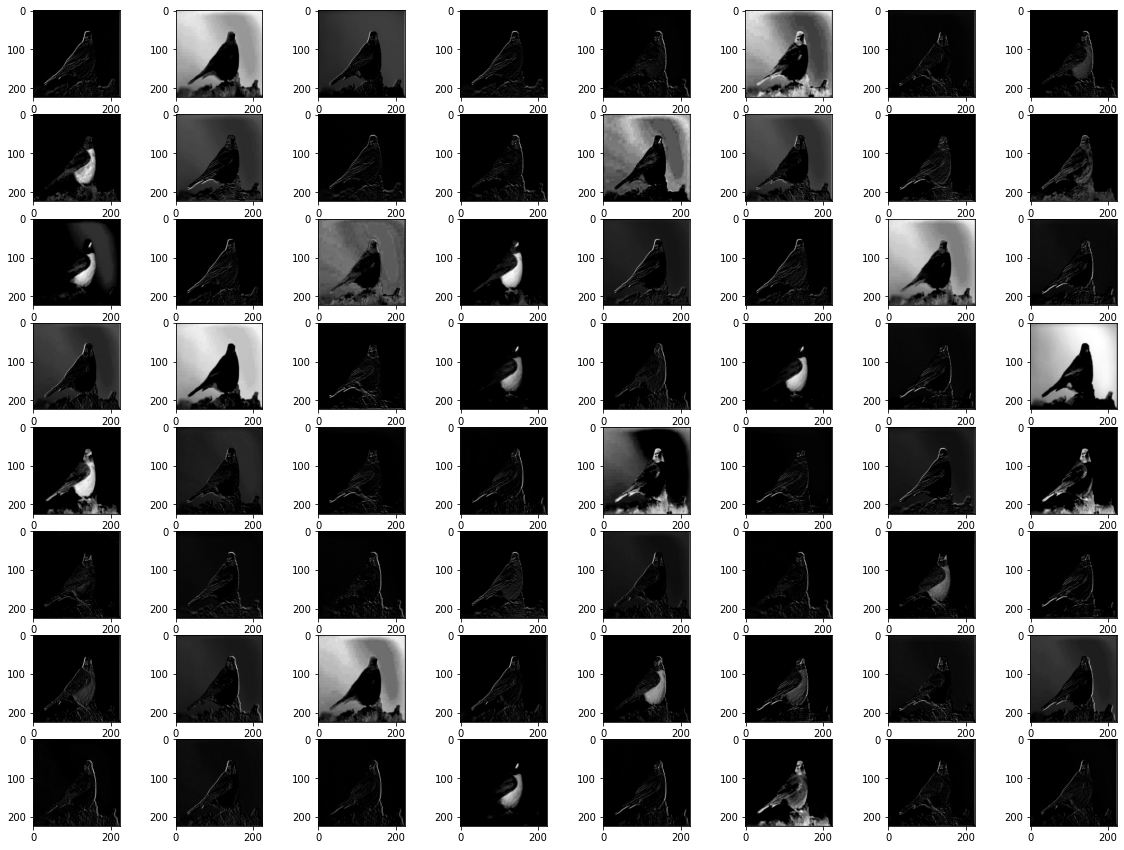

In [12]:
#calculating features_map
features = model.predict(image)

fig = pyplot.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(features[0,:,:,i-1] , cmap='gray')
    
pyplot.show()


Now we will visualise features of other layers.

In [13]:
model2 = VGG16()

In [14]:
blocks = [ 2, 5 , 9 , 13 , 17]
outputs = [model2.layers[i].output for i in blocks]

model2 = Model( inputs= model2.inputs, outputs = outputs)

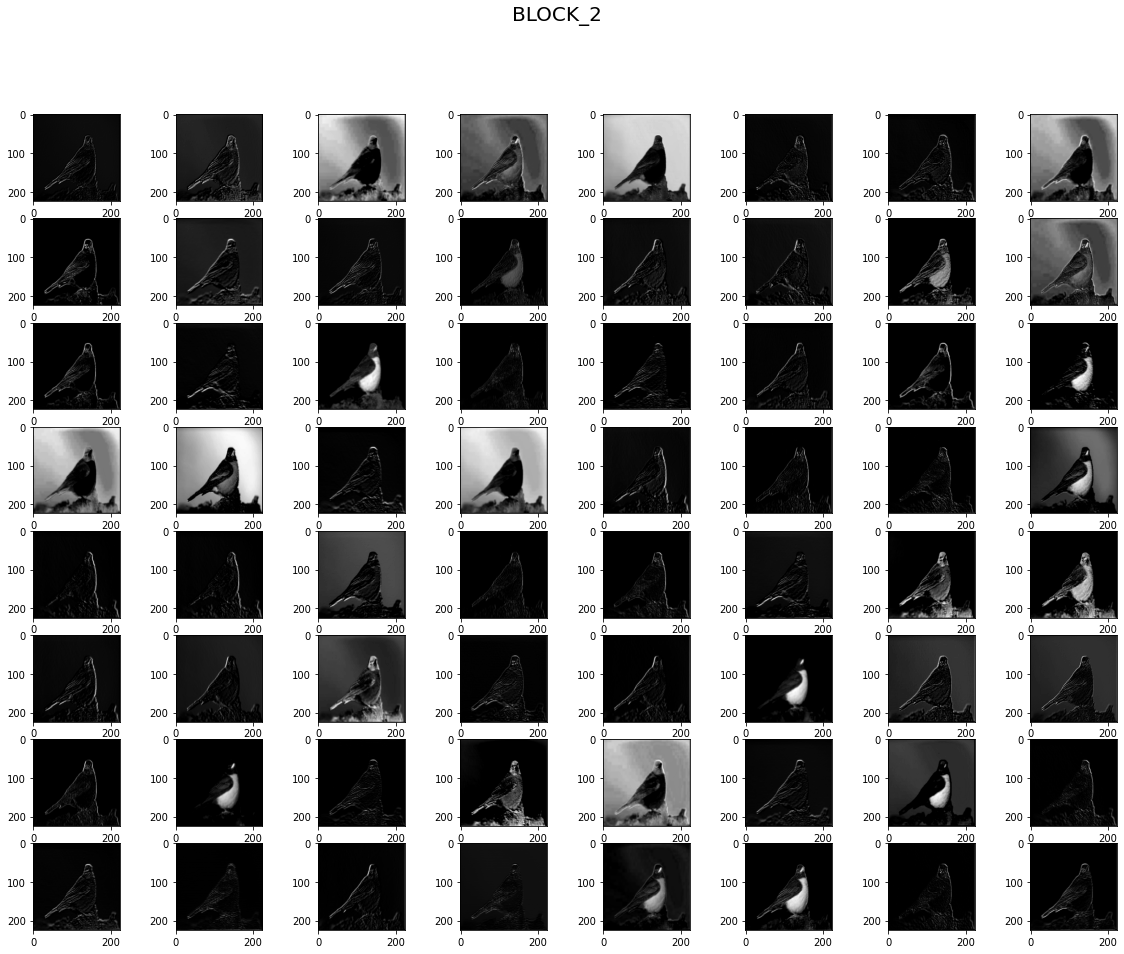

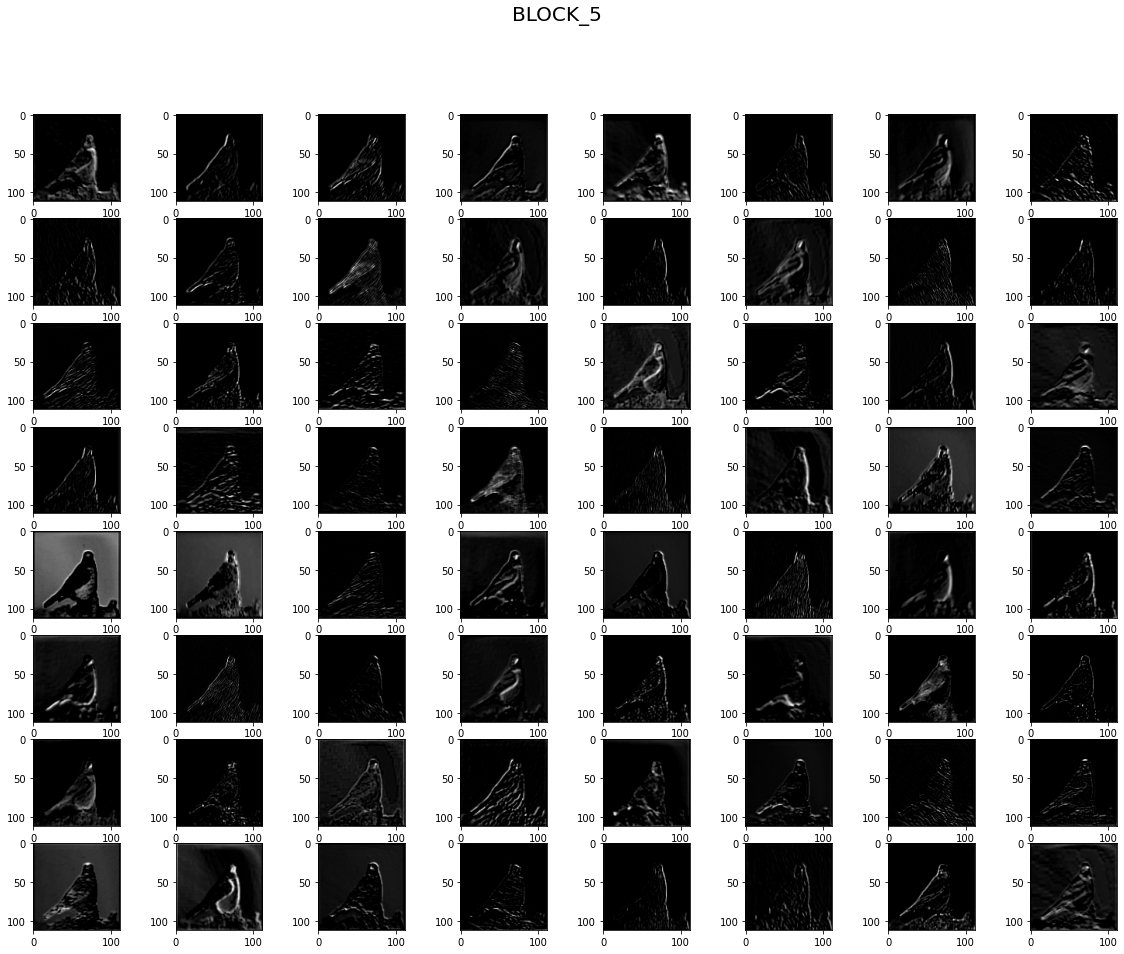

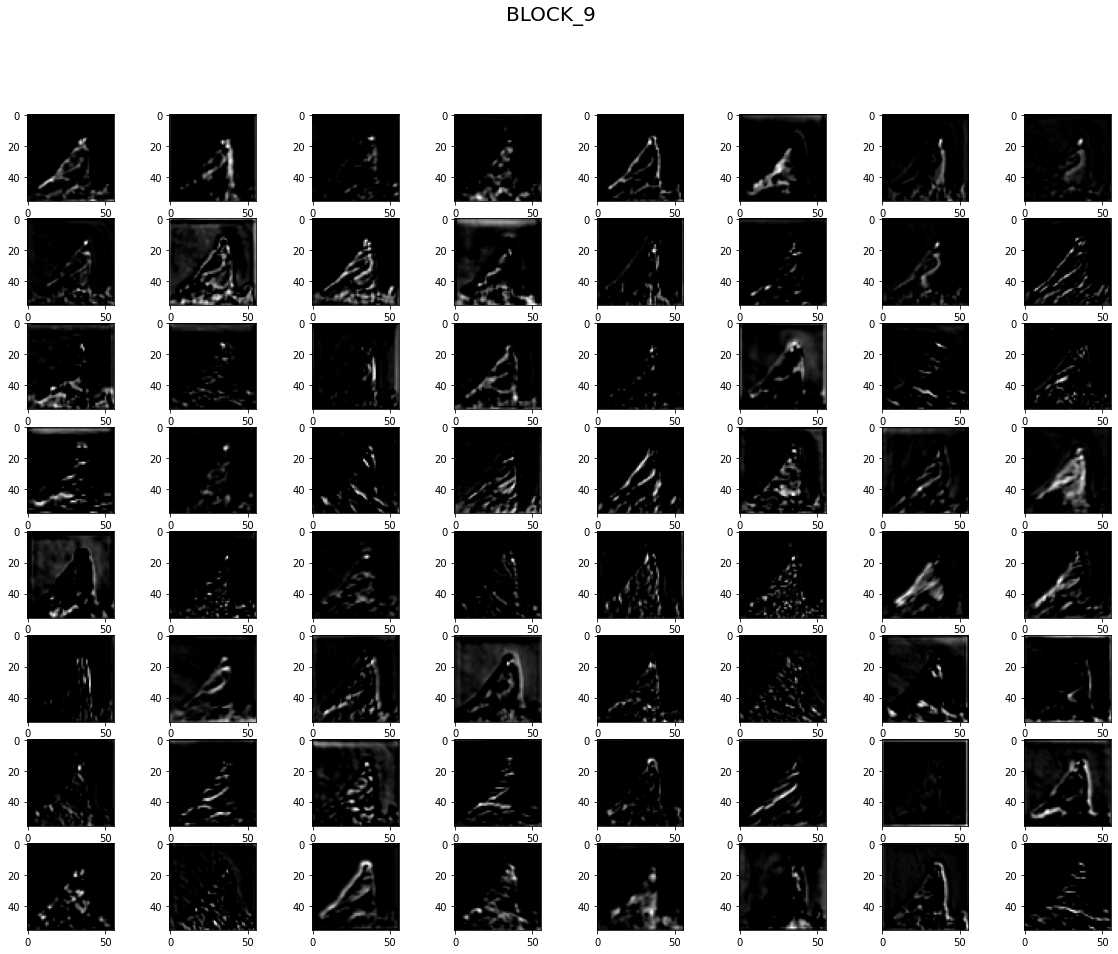

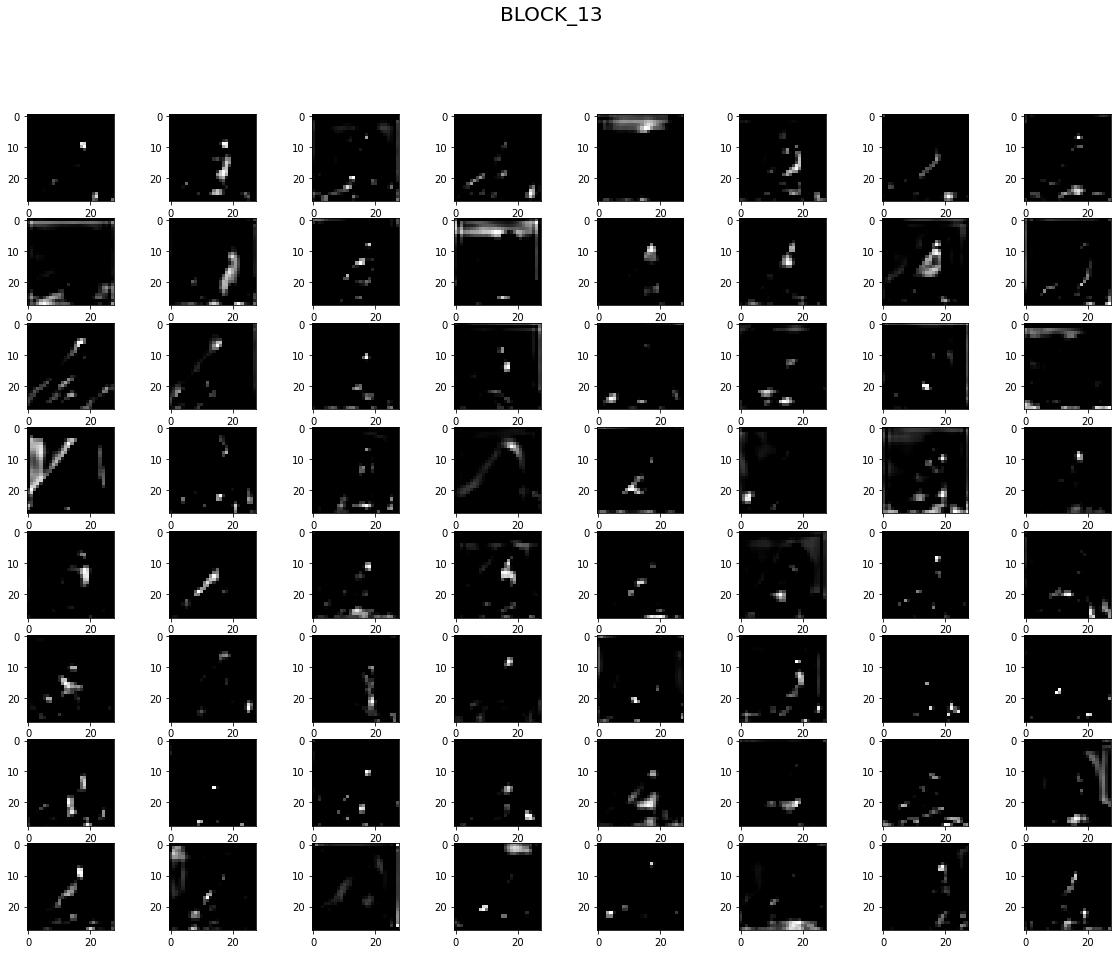

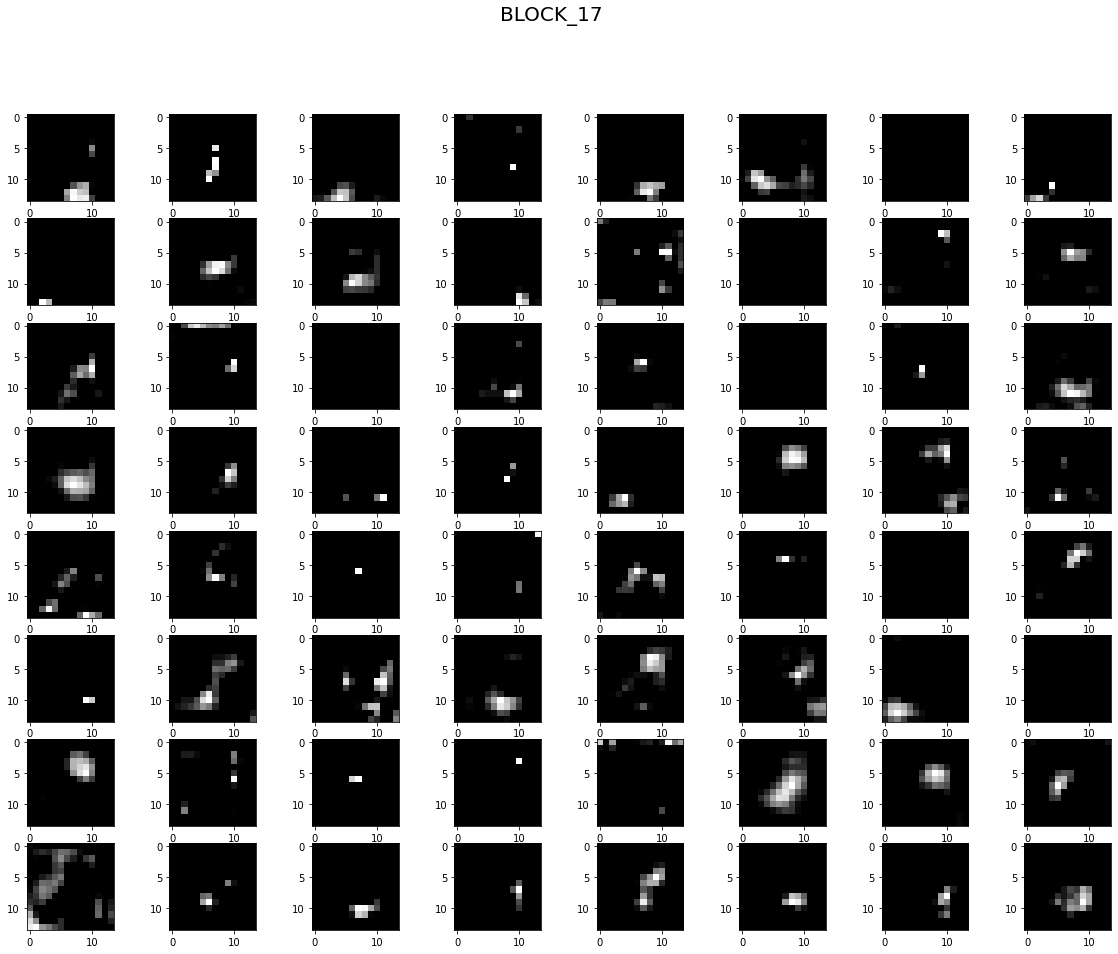

In [15]:
feature_map = model2.predict(image)

for i,fmap in zip(blocks,feature_map):
    fig = pyplot.figure(figsize=(20,15))
    #https://stackoverflow.com/a/12444777
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):

        pyplot.subplot(8,8,i)
        pyplot.imshow(fmap[0,:,:,i-1] , cmap='gray')
    
pyplot.show()